In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util.cifar10_loader import Cifar10Loader
from util.data_visualizer import DataVisualizer

### Load and Visualize CIFAR 10 Data into train, test

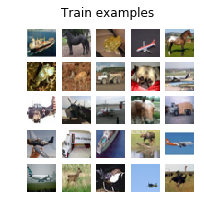

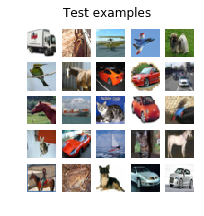

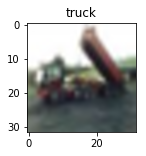

In [2]:
model_path = './models'
data_loader = Cifar10Loader()
dv = DataVisualizer()

X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar, labels = data_loader.load_cifar10('./Datasets/cifar-10')

# data_visualizer expects unflatted images
dv.visualize_data(X_train_cifar, 'Train examples')
dv.visualize_data(X_test_cifar, 'Test examples')

# Flatten data
X_train_cifar = X_train_cifar.reshape(X_train_cifar.shape[0], -1)
X_test_cifar = X_test_cifar.reshape(X_test_cifar.shape[0], -1)

# Verify Flattened data
image_id = 2
dv.visualize_image(X_train_cifar[image_id].reshape(32, 32, 3), labels[y_train_cifar[image_id]])

# Utilities

In [3]:
from scipy.special import expit

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_alternate(x):
    return expit(x)

# Division by Std dev not needed as the initial image is already in range of 0 to 1 
# due to earlier division by 255. So now all the different features (pixels) are in similar scale.
def scale_features(X, X_mean=None, X_std=None, divide_by_std_dev=False, view_hists=False):
    if X_mean is None:
        X_mean = np.mean(X, axis=0)
    if X_std is None:
        X_std = np.std(X, axis=0)
    X_1 = X - X_mean
    X_2 = X_1/X_std

    if view_hists == True:
        fig, axes1 = plt.subplots(3,1,figsize=(7,7))
        plt.suptitle('Histogram of 0th pixel of all examples')
        axes1[0].set_title('data')
        axes1[0].hist(X[:,0])
        axes1[1].set_title('data - Mean(data)')
        axes1[1].hist(X_1[:,0])
        axes1[2].set_title('(data - Mean(data))/Std_dev(data)')
        axes1[2].hist(X_2[:,0])

    if divide_by_std_dev is True:
        return X_2, X_mean, X_std
    else:
        return X_1, X_mean, X_std

def append_ones(X):
    return np.concatenate((X, np.ones((X.shape[0], 1), dtype=int)), axis=1)

def generate_binary_classification_label_from_multiclass_labels(labels, num_classes):
    # Generate 10 sets of labels for each class
    binary_labels = np.zeros((10, labels.shape[0]), dtype=int)
    for i in range(num_classes):
        binary_labels[i] = (labels == i)
    return binary_labels

# Logistic Regression

### Learnings:
- Important to initialize weights to very very small - especially for batch GD. 
  Hence dividing randomly initialized weights from a uniform distribution by number of examples. 
  Else log(1-sigmoid(w.x)) will lead to -infinity.
- For Class 0, tried input with and without dividing my standard deviation. The accuracy went slightly up when
  divided by standard deviation. It seems like a good practice to follow.
  - Without dividing my std dev:
        Accuracy on Training data =  90.956
        Accuracy on Test data =  90.97
  - Dividing my std dev:
        Accuracy on Training data =  91.24 (1550)
        Accuracy on Test data =  91.04 (302)
- This accuracy is still pretty poor as the number of predicted 1s are only 1550 among 5000 samples of this class.
  One reason can be that we have too many negative samples. 
- Regularization:
  - Using L2 norm (sum of squares of weights)
  - Prevents overfitting to the training data, ensures lowest multiple of weights is considered.
  - Penalizing large weights tends to improve generalization as no input dimension can have a very large influence on the scores all by itself. Ex: Input vector x=[1,1,1,1], and two weight vectors w1=[1,0,0,0], w2=[0.25,0.25,0.25,0.25]. Then w1.x = w2.x = 1, but L2 penalty of w1 = 1, while L2 penalty of w2 = 0.25. Therefore, w2 is preferred since it achieves a lower regularization loss. Intuitively, this is because the weights in w2 are smaller and more diffuse. Since the L2 penalty prefers smaller and more diffuse weight vectors, the final classifier is encouraged to take into account all input dimensions to small amounts rather than a few input dimensions and very strongly.This effect can improve the generalization performance of the classifiers on test images and lead to less overfitting.
  - Don't divide regularization factor by number of training examples.
  - Also, viewing weights (lots of black areas), regularization prefers lower values of weights.

- Experiment 1:
        Accuracy on Training data = 91.2775  (1304)
        Accuracy on Test data = 90.97  (317)
- Experiment 2: + regularization
        Accuracy on Training data = 91.27250000000001  (1576)
        Accuracy on Test data = 91.28  (384)
- Experiment 3: + regularization + equal number of positive and negative examples
        Accuracy on Training data = 78.50175087543772  (3976)
        Accuracy on Test data = 74.98  (3060)


### TODO:
- Try dimensionality reduction (PCA)
- Adaptive learning rate
- Momentum
- Compare against tensorflow/keras
- Display some of images which failed
- Stochastic vs Mini-batch vs batch


## Next Steps:
- Softmax Classification
- SVM

In [22]:
import time

class LogisticRegression():
    def __init__(self, verbose=True):
        self.weights = None
        self.verbose = verbose
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []
        self.val_loss_list = []
        
    def _initialize_weights(self):
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []  
        self.val_loss_list = []
        # define weights - random from uniform distribution over [0,1] or initialize to 0?
        self.weights = np.random.rand(self.num_features, 1)/self.num_train_data

    def _plot(self, list1, label1, list2=None, label2=None, title='Plot'):
        plt.figure()
        plt.title(title)
        plt.plot(list1, 'r', label=label1)
        if list2 is not None and list2 is not []:
            plt.plot(list2, 'b', label=label2)
        plt.legend()
        
    def _forward_propagate(self, X):
        y_score = sigmoid(np.dot(X, self.weights))
        y_pred = (y_score >= 0.5).astype(int)
        return y_score, y_pred
    
    def _compute_loss(self, y, y_score):
        loss_mse = -np.sum((y*np.log(y_score) + (1-y)*np.log(1-y_score)))/y.shape[0]
        return loss_mse
    
    def _compute_loss_derivative(self, X, y, y_score):
        y_diff = y_score - y
        loss_derivative = np.dot(X.T, y_diff)
        return loss_derivative

    def _update_weights(self, loss_derivative):
        self.weights = self.weights - (self.learning_rate / self.num_train_data) * loss_derivative

    def train(self, X, y, num_epochs, X_val=None, y_val=None, learning_rate=0.01, initialize_weights=False, 
              gradient_descent_type='batch', enable_regularization=False, regularization_rate=0.1):
        """
        Train the classifier
        Parameters
        ----------
        X: (N x M) nd-array of dtype=float where N is the size of train dataset, M is the number of features
        y: (N x 1) nd-array of dtype=int where N is the size of train dataset
        """
        self.learning_rate = learning_rate
        self.num_train_data = X.shape[0]
        self.num_features = X.shape[1]
        if self.num_train_data != y.shape[0]:
            raise ValueError("Train Data size and Label size don't match")

        if self.weights is None or initialize_weights is True:
            self._initialize_weights()

        for i in range(num_epochs):

            y_score, y_pred = self._forward_propagate(X)
            loss_mse = self._compute_loss(y, y_score)
            acc = self.get_accuracy(y, y_pred)

            if X_val is not None:
                y_val_score, y_val_pred = self._forward_propagate(X_val)
                val_loss_mse = self._compute_loss(y_val, y_val_score)
                val_acc = self.get_accuracy(y_val, y_val_pred)
            
            if enable_regularization is True:
                # Don't include bias while summing up weights
                regularization_penalty = regularization_rate*np.sum(np.square(self.weights[:-1]))
                loss_mse = loss_mse + regularization_penalty
                if X_val is not None:
                    val_loss_mse = val_loss_mse + regularization_penalty
            
            # Back Propagation
            loss_derivative = self._compute_loss_derivative(X, y, y_score)
            self._update_weights(loss_derivative)

            if enable_regularization is True:
                self.weights = self.weights - (learning_rate * regularization_rate)*self.weights

            self.loss_list.append(loss_mse)
            self.accuracy_list.append(acc)
            if X_val is not None:
                self.val_accuracy_list.append(val_acc)
                self.val_loss_list.append(val_loss_mse)
            
            if self.verbose is True and i%100 == 0:
                print('Iteration {}: Accuracy = {} Loss = {}'.format(i, acc, loss_mse))

        self._plot(self.loss_list, 'Training Loss', self.val_loss_list, 'Validation Loss', 
                   title='Training and Validation Loss')
        self._plot(self.accuracy_list, 'Training Accuracy', self.val_accuracy_list, 'Validation Accuracy', 
                   title='Training and Validation Accuracy')
        
        
    def predict(self, X):
        _, y_pred = self._forward_propagate(X)
        return y_pred

    def get_accuracy(self, y_ground_truth, y_predicted):
        """
        Computes accuracy
        Parameters
        ----------
        y_ground_truth: (N x 1) nd-array of dtype=int
        y_predicted: (N x 1) nd-array of dtype=int
        Returns:
        accuracy of type float
        """
        return(100*np.mean(y_predicted == y_ground_truth))
    
    def save_model(self, filename):
        np.save(filename, self.weights)

    def load_model(self, filename):
        self.weights = np.load(filename)

    def visualize_weights(self):
        weight_image = self.weights[:-1].reshape(32, 32, 3)
        print("Bias = ", self.weights[-1])
        fig, axes1 = plt.subplots(4,1,figsize=(7,7))
        plt.suptitle('Weights')
        axes1[0].set_title('rgb')
        axes1[0].imshow(weight_image)
        axes1[1].set_title('r')
        axes1[1].imshow(weight_image[:,:,0])
        axes1[2].set_title('g')
        axes1[2].imshow(weight_image[:,:,1])
        axes1[3].set_title('b')
        axes1[3].imshow(weight_image[:,:,2])

### Test Logistic regression for Class = 0

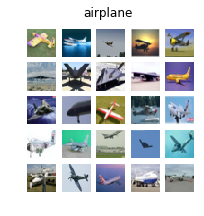

In [5]:
class_id = 0
dv.visualize_data_of_class(X_train_cifar.reshape(50000, 32, 32, 3), y_train_cifar, class_id, title=labels[class_id])

### Generate Correct Features and Labels

In [6]:
def preprocess_features(train_features, test_features, divide_by_std_dev=True):
    X_train, X_mean, X_std = scale_features(train_features, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_train = append_ones(X_train)

    X_test,_,_ = scale_features(test_features, X_mean=X_mean, X_std=X_std, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_test = append_ones(X_test)
    return X_train, X_test

def get_binary_labels_for_class(train_labels, test_labels, class_id):
    train_labels_binary = generate_binary_classification_label_from_multiclass_labels(train_labels, 10)
    y_train = train_labels_binary[class_id].reshape(-1, 1)

    test_labels_binary = generate_binary_classification_label_from_multiclass_labels(test_labels, 10)
    y_test = test_labels_binary[class_id].reshape(-1, 1)
    return y_train, y_test

### Split training into training and validation data

In [7]:
def split_train_validation_data(X, y, split=0.8):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    X_train = X[indexes[:int(split*X.shape[0])]]
    y_train = y[indexes[:int(split*X.shape[0])]]    
    X_val = X[indexes[int(split*X.shape[0]):]]
    y_val = y[indexes[int(split*X.shape[0]):]]    
    return X_train, y_train, X_val, y_val

## Experiment 1 - default

Iteration 0: Accuracy = 57.2725 Loss = 0.6919062130636326
Iteration 100: Accuracy = 82.1 Loss = 0.5370165880676838
Iteration 200: Accuracy = 88.5525 Loss = 0.4559171544419656
Iteration 300: Accuracy = 90.51249999999999 Loss = 0.40289848026154784
Iteration 400: Accuracy = 90.92 Loss = 0.36681252895566374
Iteration 500: Accuracy = 91.16250000000001 Loss = 0.3413201635845269
Iteration 600: Accuracy = 91.14999999999999 Loss = 0.3227081496812416
Iteration 700: Accuracy = 91.1675 Loss = 0.3087257802034288
Iteration 800: Accuracy = 91.1275 Loss = 0.2979601491384241
Iteration 900: Accuracy = 91.14 Loss = 0.2894941572922422
Iteration 1000: Accuracy = 91.115 Loss = 0.28271397268263615
Iteration 1100: Accuracy = 91.105 Loss = 0.27719719842240786
Iteration 1200: Accuracy = 91.10000000000001 Loss = 0.2726458583138242
Iteration 1300: Accuracy = 91.10000000000001 Loss = 0.2688450258288173
Iteration 1400: Accuracy = 91.0875 Loss = 0.2656365659808864
Iteration 1500: Accuracy = 91.0875 Loss = 0.26290203

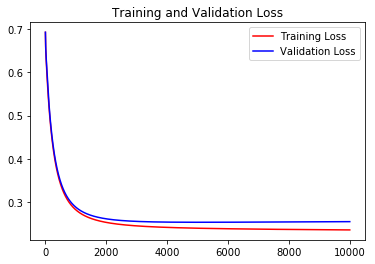

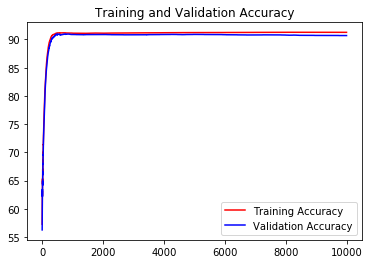

In [20]:
X_train, X_test = preprocess_features(X_train_cifar, X_test_cifar, divide_by_std_dev=True)
y_train, y_test = get_binary_labels_for_class(y_train_cifar, y_test_cifar, class_id)
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.8)

num_epochs = 10000
lr = LogisticRegression()
lr.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01)

Accuracy on Training data = 91.2775  (1304)
Accuracy on Test data = 90.97  (317)
Bias =  [-2.94565812]


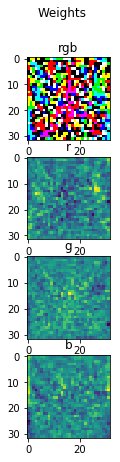

In [9]:
model_file = "logistic_regression_cifar10_class{}_epochs{}_divided_by_std_dev_{}.npy".format(class_id, num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
lr.save_model(model_file)

y_pred = lr.predict(X_train)
print("Accuracy on Training data = {}  ({})".format(lr.get_accuracy(y_train, y_pred), np.sum(y_pred)))

y_pred = lr.predict(X_test)
print("Accuracy on Test data = {}  ({})".format(lr.get_accuracy(y_test, y_pred), np.sum(y_pred)))

#lr.load_model('./models/logistic_regression_cifar10_class0_epochs10000_divided_by_std_dev_2017_05_02-22_31_10.npy');
lr.visualize_weights()

## Experiment 2: Test with regularization

Iteration 0: Accuracy = 57.2075 Loss = 0.6918749906414128
Iteration 100: Accuracy = 81.5825 Loss = 0.5424993531537433
Iteration 200: Accuracy = 87.79 Loss = 0.47079439164004194
Iteration 300: Accuracy = 89.94 Loss = 0.4268620013829852
Iteration 400: Accuracy = 90.73750000000001 Loss = 0.39859221688696445
Iteration 500: Accuracy = 90.99249999999999 Loss = 0.3796524236140235
Iteration 600: Accuracy = 91.1125 Loss = 0.3665466673400071
Iteration 700: Accuracy = 91.1525 Loss = 0.3572436838050101
Iteration 800: Accuracy = 91.185 Loss = 0.3505069021523487
Iteration 900: Accuracy = 91.225 Loss = 0.3455518985330621
Iteration 1000: Accuracy = 91.2175 Loss = 0.34186301789177415
Iteration 1100: Accuracy = 91.21249999999999 Loss = 0.3390908099781681
Iteration 1200: Accuracy = 91.2325 Loss = 0.33699229151611665
Iteration 1300: Accuracy = 91.2325 Loss = 0.33539483718371116
Iteration 1400: Accuracy = 91.245 Loss = 0.3341736030873773
Iteration 1500: Accuracy = 91.245 Loss = 0.3332369713738824
Iteration

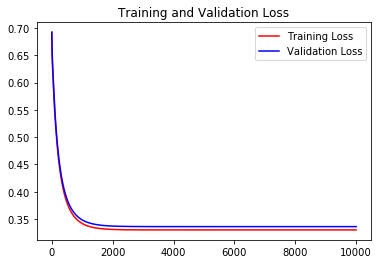

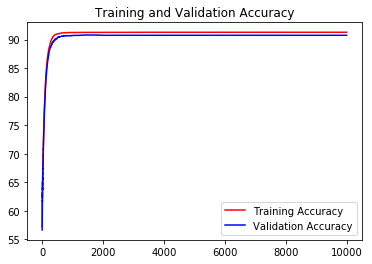

In [10]:
X_train, X_test = preprocess_features(X_train_cifar, X_test_cifar, divide_by_std_dev=True)
y_train, y_test = get_binary_labels_for_class(y_train_cifar, y_test_cifar, class_id)
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.8)

num_epochs = 10000
lr = LogisticRegression()
lr.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, 
         enable_regularization=True, regularization_rate=0.1)

Accuracy on Training data = 91.27250000000001  (1576)
Accuracy on Test data = 91.28  (384)
Bias =  [-1.30992075]


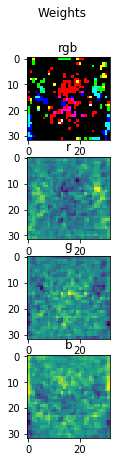

In [11]:
model_file = "logistic_regression_cifar10_class{}_epochs{}_divided_by_std_dev_regularized_{}.npy".format(class_id, num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
lr.save_model(model_file)

y_pred = lr.predict(X_train)
print("Accuracy on Training data = {}  ({})".format(lr.get_accuracy(y_train, y_pred), np.sum(y_pred)))

y_pred = lr.predict(X_test)
print("Accuracy on Test data = {}  ({})".format(lr.get_accuracy(y_test, y_pred), np.sum(y_pred)))

lr.visualize_weights()

## Experiment 3: Test with equal number of positive and negative examples

In [12]:
indexes = np.array(np.where(y_train_cifar == class_id)).flatten()

# I can either consider all images of just one other class or 555 images from each of the other 9 classes.
classes = list(range(0, 10))
classes.remove(class_id)
for i in classes:
    indexes = np.concatenate((indexes, np.array(np.where(y_train_cifar == i)).flatten()[:555]))

X_train_subset = X_train_cifar[indexes]
y_train_subset = y_train_cifar[indexes]

X_train, X_test = preprocess_features(X_train_subset, X_test_cifar, divide_by_std_dev=True)
y_train, y_test = get_binary_labels_for_class(y_train_subset, y_test_cifar, class_id)
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.8)

Iteration 0: Accuracy = 65.58279139569785 Loss = 0.6768169587403435
Iteration 100: Accuracy = 76.65082541270635 Loss = 0.5132094681732758
Iteration 200: Accuracy = 77.06353176588294 Loss = 0.5084245813920631
Iteration 300: Accuracy = 77.3886943471736 Loss = 0.5065095894528547
Iteration 400: Accuracy = 77.71385692846422 Loss = 0.5056908172520636
Iteration 500: Accuracy = 77.88894447223612 Loss = 0.5054025327251586
Iteration 600: Accuracy = 78.01400700350175 Loss = 0.5053983511963483
Iteration 700: Accuracy = 78.07653826913456 Loss = 0.5055504851463509
Iteration 800: Accuracy = 78.12656328164081 Loss = 0.5057862253513725
Iteration 900: Accuracy = 78.13906953476739 Loss = 0.5060623206152082
Iteration 1000: Accuracy = 78.15157578789395 Loss = 0.5063526119049315
Iteration 1100: Accuracy = 78.2016008004002 Loss = 0.5066413232950965
Iteration 1200: Accuracy = 78.21410705352676 Loss = 0.506919151866091
Iteration 1300: Accuracy = 78.2016008004002 Loss = 0.5071808858917949
Iteration 1400: Accura

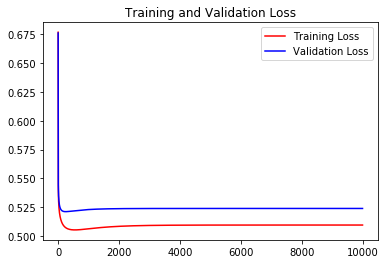

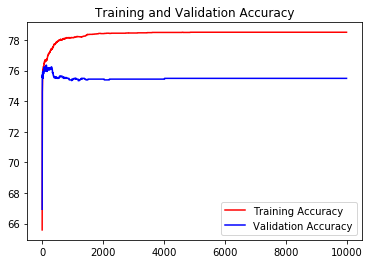

In [13]:
num_epochs = 10000
lr = LogisticRegression()
lr.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, 
         enable_regularization=True, regularization_rate=0.1)

Accuracy on Training data = 78.50175087543772  (3976)
Accuracy on Test data = 74.98  (3060)
Bias =  [-0.00429889]


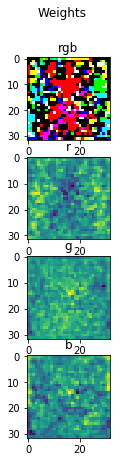

In [14]:
model_file = "logistic_regression_cifar10_class{}_epochs{}_equal_neg_pos_divided_by_std_dev_regularized_{}.npy".format(class_id, num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
lr.save_model(model_file)

y_pred = lr.predict(X_train)
print("Accuracy on Training data = {}  ({})".format(lr.get_accuracy(y_train, y_pred), np.sum(y_pred)))

y_pred = lr.predict(X_test)
print("Accuracy on Test data = {}  ({})".format(lr.get_accuracy(y_test, y_pred), np.sum(y_pred)))

lr.visualize_weights()